In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
load_dotenv()
import os

In [3]:
def get_groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7, max_tokens=2000
    )

llm = get_groq_llm()

In [4]:
class JokeState(TypedDict):

    topic: str
    joke: str
    explanation: str


In [5]:
def generate_joke(state: JokeState):

    prompt = f'generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content

    return {'joke': response}

In [6]:
def generate_explanation(state: JokeState):

    prompt = f'write an explanation for the joke - {state["joke"]}'
    response = llm.invoke(prompt).content

    return {'explanation': response}

In [7]:
graph = StateGraph(JokeState)

graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

checkpointer = InMemorySaver()

workflow = graph.compile(checkpointer=checkpointer)

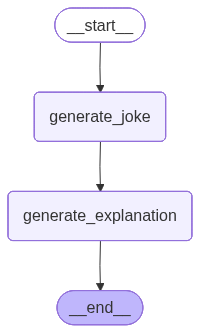

In [8]:
workflow

In [9]:
config1 = {"configurable": {"thread_id": "1"}}
workflow.invoke({'topic':'pizza'}, config=config1)

{'topic': 'pizza',
 'joke': 'Why did the pizza go to therapy?  \n\nBecause it felt *crust*ed out and *cheddared* under pressure! 🍕😄',
 'explanation': '**Why the joke works – a quick “crust”‑level explanation**\n\n| Element | What it does | Why it’s funny |\n|---------|--------------|----------------|\n| **Anthropomorphism** | The pizza is treated as a person who can “feel” and go to therapy. | It’s absurd to imagine a slice of dough having emotions, so the setup already feels like a playful exaggeration. |\n| **Wordplay on “crust”** | *“Crusted out”* sounds like the phrase *“crushed out”* (meaning exhausted or overwhelmed) but literally refers to the pizza’s outer edge. | The double meaning lets us think of both a tired person and a literal crust that’s become hard or burnt. |\n| **Made‑up verb “cheddared”** | A playful mash‑up of *cheddar* (the cheese) and a verb ending, implying the pizza is “cheddared” (cheddar‑filled or “chewed up”) under pressure. | It’s a goofy, on‑the‑nose pun t

In [10]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to therapy?  \n\nBecause it felt *crust*ed out and *cheddared* under pressure! 🍕😄', 'explanation': '**Why the joke works – a quick “crust”‑level explanation**\n\n| Element | What it does | Why it’s funny |\n|---------|--------------|----------------|\n| **Anthropomorphism** | The pizza is treated as a person who can “feel” and go to therapy. | It’s absurd to imagine a slice of dough having emotions, so the setup already feels like a playful exaggeration. |\n| **Wordplay on “crust”** | *“Crusted out”* sounds like the phrase *“crushed out”* (meaning exhausted or overwhelmed) but literally refers to the pizza’s outer edge. | The double meaning lets us think of both a tired person and a literal crust that’s become hard or burnt. |\n| **Made‑up verb “cheddared”** | A playful mash‑up of *cheddar* (the cheese) and a verb ending, implying the pizza is “cheddared” (cheddar‑filled or “chewed up”) under pressure. | It’s a goofy

# ## Intermediate States

In [11]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to therapy?  \n\nBecause it felt *crust*ed out and *cheddared* under pressure! 🍕😄', 'explanation': '**Why the joke works – a quick “crust”‑level explanation**\n\n| Element | What it does | Why it’s funny |\n|---------|--------------|----------------|\n| **Anthropomorphism** | The pizza is treated as a person who can “feel” and go to therapy. | It’s absurd to imagine a slice of dough having emotions, so the setup already feels like a playful exaggeration. |\n| **Wordplay on “crust”** | *“Crusted out”* sounds like the phrase *“crushed out”* (meaning exhausted or overwhelmed) but literally refers to the pizza’s outer edge. | The double meaning lets us think of both a tired person and a literal crust that’s become hard or burnt. |\n| **Made‑up verb “cheddared”** | A playful mash‑up of *cheddar* (the cheese) and a verb ending, implying the pizza is “cheddared” (cheddar‑filled or “chewed up”) under pressure. | It’s a goof

In [12]:
config2 = {"configurable": {"thread_id": "2"}}
workflow.invoke({'topic':'pasta'}, config=config2)

{'topic': 'pasta',
 'joke': 'Why did the spaghetti break up with the lasagna?  \n\nBecause it got tired of all the “layer‑by‑layer” drama and wanted something a little more “pasta‑tively” spontaneous!',
 'explanation': '**Why the joke works – a breakdown of the word‑play and absurdity**\n\n| Element | What it’s doing | Why it’s funny |\n|---------|-----------------|----------------|\n| **“Why did the spaghetti break up with the lasagna?”** | Sets up the classic “Why did X break up with Y'}

In [13]:
workflow.get_state(config2)

StateSnapshot(values={'topic': 'pasta', 'joke': 'Why did the spaghetti break up with the lasagna?  \n\nBecause it got tired of all the “layer‑by‑layer” drama and wanted something a little more “pasta‑tively” spontaneous!', 'explanation': '**Why the joke works – a breakdown of the word‑play and absurdity**\n\n| Element | What it’s doing | Why it’s funny |\n|---------|-----------------|----------------|\n| **“Why did the spaghetti break up with the lasagna?”** | Sets up the classic “Why did X break up with Y'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0e477f-9210-6000-8002-898614f88586'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-12-29T05:33:58.041577+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0e477f-7b93-6c3c-8001-c4a1d62ed9fc'}}, tasks=(), interrupts=())

# ### Time Travel
# 
# ## we can go back to any previous node to do the execution again for debugging & changing the input as well


## so let's go to the pizza example where we got the topic & we want to go back to joke generation step & further steps.
## In order to do that we need to grab the checkpoint id where we got the topic. We can get it from the state history.


In [14]:
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'pasta', 'joke': 'Why did the spaghetti break up with the lasagna?  \n\nBecause it got tired of all the “layer‑by‑layer” drama and wanted something a little more “pasta‑tively” spontaneous!', 'explanation': '**Why the joke works – a breakdown of the word‑play and absurdity**\n\n| Element | What it’s doing | Why it’s funny |\n|---------|-----------------|----------------|\n| **“Why did the spaghetti break up with the lasagna?”** | Sets up the classic “Why did X break up with Y'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0e477f-9210-6000-8002-898614f88586'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-12-29T05:33:58.041577+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0e477f-7b93-6c3c-8001-c4a1d62ed9fc'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'topic': 'pasta', 'joke': 'Why did the spaghetti break up with the lasa

In [15]:
workflow.get_state({"configurable": {"thread_id": "1", "checkpoint_id": "1f0e4775-9a74-6778-8000-a0ba93bce9ef"}}) ## checkpoint id from pizza run where we haver the topic but we need to generate the joke


StateSnapshot(values={'topic': 'pizza'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f0e4775-9a74-6778-8000-a0ba93bce9ef'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-12-29T05:29:30.486143+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e4775-9a72-628e-bfff-692de1ccddbb'}}, tasks=(PregelTask(id='823e43a4-f349-4e77-ff9e-ed4a53352bb1', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result={'joke': 'Why did the pizza go to therapy?  \n\nBecause it felt *crust*ed out and *cheddared* under pressure! 🍕😄'}),), interrupts=())

In [16]:
workflow.invoke(None, {"configurable": {"thread_id": "1", "checkpoint_id": "1f0e4775-9a74-6778-8000-a0ba93bce9ef"}})


{'topic': 'pizza',
 'joke': 'Why did the pizza apply for a job?\n\nBecause it wanted to get a *slice* of the action! 🍕😄',
 'explanation': "**Explanation of the joke**\n\n> *Why did the pizza apply for a job?  \n>  Because it wanted to get a *slice* of the action!*\n\nThis joke is a classic example of a **pun**—a play on words that relies on a double meaning. Let’s break it down:\n\n| Part of the joke | Literal meaning | Figurative / pun meaning |\n|------------------|-----------------|--------------------------|\n| **“Pizza”** | A food item made of dough, sauce, cheese, etc. | Personified as a character capable of making decisions. |\n| **“Apply for a job”** | To submit a request to work somewhere. | Indicates the pizza wants to be employed. |\n| **“Slice”** | A portion of a pizza. | Also a metaphor for “a piece” or “a share” of something. |\n| **“Slice of the action”** | A part of an exciting event or activity. | A humorous way of saying “I want to be part of what's happening.” |\n\n#

# ## now we can see more Snapshots due to the re-execution

In [17]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza apply for a job?\n\nBecause it wanted to get a *slice* of the action! 🍕😄', 'explanation': "**Explanation of the joke**\n\n> *Why did the pizza apply for a job?  \n>  Because it wanted to get a *slice* of the action!*\n\nThis joke is a classic example of a **pun**—a play on words that relies on a double meaning. Let’s break it down:\n\n| Part of the joke | Literal meaning | Figurative / pun meaning |\n|------------------|-----------------|--------------------------|\n| **“Pizza”** | A food item made of dough, sauce, cheese, etc. | Personified as a character capable of making decisions. |\n| **“Apply for a job”** | To submit a request to work somewhere. | Indicates the pizza wants to be employed. |\n| **“Slice”** | A portion of a pizza. | Also a metaphor for “a piece” or “a share” of something. |\n| **“Slice of the action”** | A part of an exciting event or activity. | A humorous way of saying “I want to be part of what'

# #### Updating State

In [18]:
workflow.update_state({"configurable": {"thread_id": "1", "checkpoint_id": "1f0e4775-9a74-6778-8000-a0ba93bce9ef", "checkpoint_ns": ""}}, {'topic':'Burger'})


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e478d-d21c-6e92-8001-ede878bbc919'}}

# ## now we have updated the state with topic as samosa, one more snapshot will be created

In [19]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'Burger'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e478d-d21c-6e92-8001-ede878bbc919'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-12-29T05:40:20.567405+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e4775-9a74-6778-8000-a0ba93bce9ef'}}, tasks=(PregelTask(id='5045ca89-6fb6-7417-b159-6fb478377194', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza apply for a job?\n\nBecause it wanted to get a *slice* of the action! 🍕😄', 'explanation': "**Explanation of the joke**\n\n> *Why did the pizza apply for a job?  \n>  Because it wanted to get a *slice* of the action!*\n\nThis joke is a classic example of a **pun**—a play on words that relies on a double meaning.

# ## and to execute the workflow from the updated state (samosa) we need to pass the checkpoint id of samosa snapshot



In [20]:
workflow.invoke(None, {"configurable": {"thread_id": "1", "checkpoint_id": "1f0e478d-d21c-6e92-8001-ede878bbc919"}})


{'topic': 'Burger',
 'joke': 'Why did the burger go to therapy?\n\nBecause it had too many “lettuce” issues and couldn’t stop feeling “meat” of its own problem!',
 'explanation': '**Why the joke works – a quick breakdown**\n\n| Element | What’s happening | Why it’s funny |\n|---------|------------------|----------------|\n| **The set‑up** | “Why did the burger go to therapy?” | It sets up an absurd premise: a burger, a food item, is a person with psychological problems. The reader instantly knows we’re in the realm of a pun or a play on words. |\n| **“Too many ‘lettuce’ issues”** | *Lettuce* is a vegetable that’s a key ingredient in most burgers. The joke replaces the ordinary “lettuce” with the phrase “lettuce” (pronounced *let‑us*). So the burger is literally “letting us” (lettuce) issues – it can’t stop holding onto them. | The pun works on two levels: the literal ingredient and the phrase “let us.” It’s a classic *word‑play* joke, where a homophone (lettuce/let us) creates a double

In [21]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'Burger', 'joke': 'Why did the burger go to therapy?\n\nBecause it had too many “lettuce” issues and couldn’t stop feeling “meat” of its own problem!', 'explanation': '**Why the joke works – a quick breakdown**\n\n| Element | What’s happening | Why it’s funny |\n|---------|------------------|----------------|\n| **The set‑up** | “Why did the burger go to therapy?” | It sets up an absurd premise: a burger, a food item, is a person with psychological problems. The reader instantly knows we’re in the realm of a pun or a play on words. |\n| **“Too many ‘lettuce’ issues”** | *Lettuce* is a vegetable that’s a key ingredient in most burgers. The joke replaces the ordinary “lettuce” with the phrase “lettuce” (pronounced *let‑us*). So the burger is literally “letting us” (lettuce) issues – it can’t stop holding onto them. | The pun works on two levels: the literal ingredient and the phrase “let us.” It’s a classic *word‑play* joke, where a homophone (lettuce/let 

# ### Fault Tolerance kind of similar as human in the loop (In HITL we do it perpupose fully using langraph interrupt)

In [ ]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict
import time

In [ ]:
# 1. Define the state
class CrashState(TypedDict):
    input: str
    step1: str
    step2: str
    step3: str

In [ ]:
# 2. Define steps
def step_1(state: CrashState) -> CrashState:
    print("✅ Step 1 executed")
    return {"step1": "done", "input": state["input"]}

def step_2(state: CrashState) -> CrashState:
    print("⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)")
    time.sleep(10)  # Simulate long-running hang
    return {"step2": "done"}

def step_3(state: CrashState) -> CrashState:
    print("✅ Step 3 executed")
    return {"step3": "done"}


In [ ]:
# 3. Build the graph
builder = StateGraph(CrashState)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.set_entry_point("step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

In [ ]:
graph

In [ ]:
try:
    print("▶️ Running graph: Please manually interrupt during Step 2...")
    graph.invoke({"input": "start"}, config={"configurable": {"thread_id": 'thread-1'}})
except KeyboardInterrupt:
    print("❌ Kernel manually interrupted (crash simulated).")


In [ ]:
graph.get_state({"configurable": {"thread_id": 'thread-1'}})

In [ ]:
# 6. Re-run to show fault-tolerant resume
print("\n🔁 Re-running the graph to demonstrate fault tolerance...")
final_state = graph.invoke(None, config={"configurable": {"thread_id": 'thread-1'}})
print("\n✅ Final State:", final_state)



In [ ]:
list(graph.get_state_history({"configurable": {"thread_id": 'thread-1'}}))